# Using RL to learn to Checkmate

This will be much more in depth: using a much larger environment (based on the number of moves there are at any given time). We're still going to use the techniques discussed: game-states, movement, and a q-table.

***In order to make the q-table a reasonable size, we are going to use a 4x4 board instead of 8x8 since every piece location combination needs to be recorded.***


First off, we need to code in the Chess aspect. Since we are making an abbreviated game of chess (with limited pieces), we'll make our game set only have the pieces we want to use. This can later be expanded.
- Board
  - 8x8 matrix
- King
  - Possible moves: One space in any direction (horizontal / diagonal)
- Rook
  - Possible moves: 1-3 spaces in each horizontal direction (N-S-E-W)
  
Rules:
- Check
  - The king is being attacked.
- Checkmate
  - End of the game.
  
***

*In each game position, the agent will make either a king move or a rook move. Since some of those moves will be illegal (the piece would end up in check, or off the board, or going through another piece!), there will need to be some sort of mask which prohibits the agent from choosing these.*

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

In [2]:
np.random.seed(2021)
plt.style.use(['ggplot', 'seaborn-talk'])

# Design Chess

In [3]:
class Board:
    def __init__(self, setup_with=list(), n_squares=4):
        self.n_squares = n_squares
        self.board = np.zeros((self.n_squares, self.n_squares), dtype='object')
        for p in setup_with:
            self.board[tuple(p.position)] = p
        
    def __str__(self):
        for x in range(self.n_squares):
            for y in range(self.n_squares):
                if self.board[(x, y)]:
                    print(f' {self.board[(x, y)]} ', end='')
                else:
                    print(' . ', end='')
            print()
        return ''
    
    def __repr__(self):
        self.__str__()
        return ''
    
    def in_bounds(self, coord):
        y, x = coord
        if (x < 0) | (x >= self.n_squares) | (y < 0) | (y >= self.n_squares):
            return False
        return True
    
    def is_occupied(self, coord):
        if self.board[coord]:
            return True
        return False
        
        
class Piece:
    def __init__(self, position, is_white: bool):
        """Position can be coordinates `(inv(y), x)` or string (`e4`)."""
        if isinstance(position, str):
            self.position = self.__interpret_position_string(position)
        else:
            self.position = np.array(position)
        self.is_white = is_white
        
    def __interpret_position_string(self, s):
        """
        Board positions like `e4` or `f6`. 
        Converted to coordinates (y, x):
        
        'a8' -> (0, 0)
        'a1' -> (7, 0)
        'h1' -> (7, 7)
        """
        
        file_dct = {
            'a': 0,
            'b': 1,
            'c': 2,
            'd': 3
        }
        return np.array([4-int(s[1]), file_dct[s[0]]])
        
class King(Piece):
    def __init__(self, position, is_white):
        super().__init__(position, is_white)
        
    def __str__(self):
        if self.is_white:
            return 'K'
        return 'k'
    
    def __repr__(self):
        return self.__str__()
    
    def all_possible_moves(self):
        # Moves one space any direction.
        movements = [np.array([x, y]) 
                     for x in range(-1, 1+1) 
                     for y in range(-1, 1+1)]
        
        # Remove standing still
        movements = [m for m in movements if not all(m == np.array([0, 0]))]
        return np.array(movements)
    
    def possible_legal(self, game):
        enemy_king = [p for p in game.player.pieces + game.computer.pieces
                      if isinstance(p, King) and p != self][0]
        adj_to_enemy_king = [tuple(enemy_king.position + n) 
                             for n in enemy_king.all_possible_moves()]
        if self.is_white:
            friendly_pieces = [p for p in game.player.pieces]
            friendly_squares = [tuple(p.position) for p in friendly_pieces]
        else:
            friendly_squares = []
            
        return [tuple(m) for m in self.all_possible_moves()
                if game.board.in_bounds(tuple(self.position + m))
                and tuple(self.position + m) not in 
                game.controlled_by('b' if self.is_white else 'w')
                and tuple(self.position + m) not in adj_to_enemy_king
                and tuple(self.position + m) not in friendly_squares]
    
    def controls(self, game):
        return [tuple(m) for m in self.all_possible_moves()
                if game.board.in_bounds(tuple(self.position + m))]
    
    
class Rook(Piece):
    def __init__(self, position, is_white):
        super().__init__(position, is_white)
        
    def __str__(self):
        if self.is_white:
            return 'R'
        return 'r'
    
    def __repr__(self):
        return self.__str__()
    
    def all_possible_moves(self):
        # Moves up to 3 spaces in all directions (n-e-s-w)
        movements = [np.array([y, 0]) for y in range(-3, 3+1)] + \
                    [np.array([0, x]) for x in range(-3, 3+1)]
        
        # Remove standing still.
        movements = [m for m in movements if not all(m == np.array([0, 0]))]
        return np.array(movements)
    
    def possible_legal(self, game):
        white_king_sq, white_rook_sq, black_king_sq = game.get_game_state()
        possible_moves = []
        for i in range(-1, -4, -1):
            new_square = tuple(self.position + (i, 0))
            if new_square == black_king_sq:
                possible_moves.append((i, 0))
                break
            elif new_square == white_king_sq:
                break
            possible_moves.append((i, 0))
        for i in range(-1, -4, -1):
            new_square = tuple(self.position + (0, i))
            if new_square == black_king_sq:
                possible_moves.append((i, 0))
                break
            elif new_square == white_king_sq:
                break
            possible_moves.append((0, i))

        for i in range(1, 4):
            new_square = tuple(self.position + (i, 0))
            if new_square == black_king_sq:
                possible_moves.append((i, 0))
                break
            elif new_square == white_king_sq:
                break
            possible_moves.append((i, 0))
        for i in range(1, 4):
            new_square = tuple(self.position + (0, i))
            if new_square == black_king_sq:
                possible_moves.append((0, i))
                break
            elif new_square == white_king_sq:
                break
            possible_moves.append((0, i))
            
        return [m for m in possible_moves if 
                game.board.in_bounds(tuple(self.position + m))]
    
    def controls(self, game):
        white_king_sq, white_rook_sq, black_king_sq = game.get_game_state()
        possible_moves = []
        for i in range(-1, -4, -1):
            new_square = tuple(self.position + (i, 0))
            if new_square == white_king_sq:
                break
            possible_moves.append((i, 0))
        for i in range(-1, -4, -1):
            new_square = tuple(self.position + (0, i))
            if new_square == white_king_sq:
                break
            possible_moves.append((0, i))

        for i in range(1, 4):
            new_square = tuple(self.position + (i, 0))
            if new_square == white_king_sq:
                break
            possible_moves.append((i, 0))
        for i in range(1, 4):
            new_square = tuple(self.position + (0, i))
            if new_square == white_king_sq:
                break
            possible_moves.append((0, i))
            
        return [m for m in possible_moves if 
                game.board.in_bounds(tuple(self.position + m))]
    
    
class Player:
    def __init__(self, pieces=list()):
        self.pieces = pieces
        
        
class Game:
    def __init__(self, white_pieces: list, black_pieces: list, board_size=4):
        self.player = Player(white_pieces)
        self.computer = Player(black_pieces)
        self.board = Board(self.player.pieces + self.computer.pieces, 
                           board_size)
        
    def get_game_state(self):
        """
        Return piece positions. 
            (w-king, w-rook, b-king)
        """
        
        pieces_dct = {
            'w-king': (-1, -1),
            'w-rook': (-1, -1),
            'b-king': self.computer.pieces[0].position
        }
        
        for p in self.player.pieces:
            if isinstance(p, King):
                pieces_dct['w-king'] = p.position
            elif isinstance(p, Rook):
                pieces_dct['w-rook'] = p.position
        return (tuple(pieces_dct.get('w-king', (0, 0))), 
                tuple(pieces_dct.get('w-rook', (0, 0))), 
                tuple(pieces_dct.get('b-king', (0, 0))))
    
    def controlled_by(self, color: str):
        """
        Squares (coordinates) that `color`-player controls.
        `color` can be one of ('w', 'b', 'white', 'black')
        """
        
        if color.lower() in ('w', 'white'):
            side = self.player
        elif color.lower() in ('b', 'black'):
            side = self.computer
            
        all_possible = []
        for p in side.pieces:
            all_possible += [tuple(p.position + a) 
                             for a in p.controls(self)]
            
        return set([coord for coord in all_possible 
                    if self.board.in_bounds(coord)])
    
    def move(self, piece, action):
        starting_coord = piece.position
        ending_coord = tuple(starting_coord + action)
        
        # Check if there's been a capture.
        if ending_coord in self.get_game_state():
            captured_piece = [
                p for p in self.player.pieces + self.computer.pieces
                if tuple(p.position) == ending_coord
            ][0]
            if captured_piece.is_white:
                
                self.player.pieces.remove(captured_piece)
            else:
                self.computer.pieces.remove(captured_piece)
                
        # Move piece, set board.
        piece.position = np.array(ending_coord)
        self.set_board()
        
    def set_board(self):
        self.board.board = np.zeros((self.board.n_squares, 
                                     self.board.n_squares), 
                                    dtype='object')
        for p in self.player.pieces + self.computer.pieces:
            self.board.board[tuple(p.position)] = p
            
    def possible_moves_for(self, color: str):
        """
        Color must be one of ('w', 'b', 'white', 'black').
        Returns a list of two lists: 
            Possbile king moves and possible rook moves.
        """
        player = self.player if color in ('w', 'white') else self.computer
        king_possible = []
        rook_possible = []
        for p in player.pieces:
            if isinstance(p, King):
                king_possible = p.possible_legal(self)
            elif isinstance(p, Rook):
                rook_possible = p.possible_legal(self)
                
        return [sorted(king_possible), sorted(rook_possible)]
    
    def __nowhere_to_run(self):
        """Returns if the black king has no legal movement squares."""
        
        if not self.computer.pieces:
            print('NO BLACK PIECES')
            print(self.board)
            time.sleep(5)
            return True
        king = self.computer.pieces[0]
        king_possible = set(
            [tuple(king.position + a) for a in king.possible_legal(self)
             if self.board.in_bounds(tuple(king.position + a))])
        white_controlled = self.controlled_by('w')
        if not king_possible - white_controlled:
            return True
        return False
    
    def __nowhere_to_hide(self):
        """
        Returns if the black king is standing on a square controlled by 
        the opponent.
        """
        
        if not self.computer.pieces:
            print('NO BLACK PIECES')
            print(self.board)
            time.sleep(5)
            return True
        
        king = self.computer.pieces[0]
        return tuple(king.position) in self.controlled_by('w')
    
    def is_stalemate(self):
        """Returns bool if the board state is stalemate."""
        return self.__nowhere_to_run() and not self.__nowhere_to_hide()
    
    def is_checkmate(self):
        """Returns bool if the board state is checkmate."""
        return self.__nowhere_to_run() and self.__nowhere_to_hide()
    
    
def convert_coord_to_square(coord):
    """Returns the string (eg: `a1`) based on a coordinate."""
    rank, file = coord
    file_dct = {
        0: 'a',
        1: 'b',
        2: 'c',
        3: 'd'
    }
    return str(file_dct[file]) + str(4 - rank)

In [4]:
def set_up_new_game():
    return Game(
        white_pieces=[King('d1', 1), Rook('a1', 1)],
        black_pieces=[King('d4', 0)],
        board_size=4
    )

## Check interface and functionality.

In [5]:
game = set_up_new_game()
print('*GAME BOARD*')
print('************')
print(game.board)
for p in game.player.pieces:
    print(p)
    print('Legal Moves:')
    print(p.possible_legal(game))
    print()
print('Controlled by white:', game.controlled_by('w'))

*GAME BOARD*
************
 .  .  .  k 
 .  .  .  . 
 .  .  .  . 
 R  .  .  K 

K
Legal Moves:
[(-1, -1), (-1, 0), (0, -1)]

R
Legal Moves:
[(-1, 0), (-2, 0), (-3, 0), (0, 1), (0, 2)]

Controlled by white: {(3, 2), (0, 0), (3, 1), (2, 0), (2, 3), (2, 2), (1, 0)}


In [6]:
# Check functionality of capturing.
king = game.computer.pieces[0]
print(game.board)

# Move the king to capture the rook and then move away.
choice_lst = [(1, -1), (1, -1), (1, -1), (-1, 1)]
for choice in choice_lst:
    game.move(king, choice)
    print(game.board)

 .  .  .  k 
 .  .  .  . 
 .  .  .  . 
 R  .  .  K 

 .  .  .  . 
 .  .  k  . 
 .  .  .  . 
 R  .  .  K 

 .  .  .  . 
 .  .  .  . 
 .  k  .  . 
 R  .  .  K 

 .  .  .  . 
 .  .  .  . 
 .  .  .  . 
 k  .  .  K 

 .  .  .  . 
 .  .  .  . 
 .  k  .  . 
 .  .  .  K 



In [7]:
def move_king_randomly(king, game, n=10):
    print('Starting Position:')
    print(game.board)
    for _ in range(n):
        print('\tAll possible:', king.possible_legal(game))
        random_move = king.possible_legal(game)[
            np.random.randint(len(king.possible_legal(game)))
        ]
        print('\tChosen:', random_move)
        game.move(king, random_move)
        print('Moved:')
        print(game.board)

In [8]:
# Test functionality of movement.
king = game.computer.pieces[0]

move_king_randomly(king, game, 30)

Starting Position:
 .  .  .  . 
 .  .  .  . 
 .  k  .  . 
 .  .  .  K 

	All possible: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (1, -1), (1, 0)]
	Chosen: (1, -1)
Moved:
 .  .  .  . 
 .  .  .  . 
 .  .  .  . 
 k  .  .  K 

	All possible: [(-1, 0), (-1, 1), (0, 1)]
	Chosen: (-1, 1)
Moved:
 .  .  .  . 
 .  .  .  . 
 .  k  .  . 
 .  .  .  K 

	All possible: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (1, -1), (1, 0)]
	Chosen: (-1, 0)
Moved:
 .  .  .  . 
 .  k  .  . 
 .  .  .  . 
 .  .  .  K 

	All possible: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0)]
	Chosen: (-1, -1)
Moved:
 k  .  .  . 
 .  .  .  . 
 .  .  .  . 
 .  .  .  K 

	All possible: [(0, 1), (1, 0), (1, 1)]
	Chosen: (1, 0)
Moved:
 .  .  .  . 
 k  .  .  . 
 .  .  .  . 
 .  .  .  K 

	All possible: [(-1, 0), (-1, 1), (0, 1), (1, 0), (1, 1)]
	Chosen: (1, 1)
Moved:
 .  .  .  . 
 .  .  .  . 
 .  k  .  . 
 .  .  .  K 

	All possible: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (1, -1), (1, 0)]
	Chosen: (0, -1)
Moved:
 .  .  .  . 
 .

In [9]:
# Check stalemate logic.
game = Game(
    white_pieces=[King('d2', 1), Rook('c1', 1)],
    black_pieces=[King('d4', 0)]
)
print(game.board)
print('Checkmate:\n\t', game.is_checkmate())
print('Stalemate:\n\t', game.is_stalemate())

 .  .  .  k 
 .  .  .  . 
 .  .  .  K 
 .  .  R  . 

Checkmate:
	 False
Stalemate:
	 True


In [10]:
# Check checkmate logic.
game = Game(
    white_pieces=[King('d2', 1), Rook('a4', 1)],
    black_pieces=[King('d4', 0)]
)
print(game.board)
print('Checkmate:\n\t', game.is_checkmate())
print('Stalemate:\n\t', game.is_stalemate())

 R  .  .  k 
 .  .  .  . 
 .  .  .  K 
 .  .  .  . 

Checkmate:
	 True
Stalemate:
	 False


In [11]:
# Get game state.
game.get_game_state()

((2, 3), (0, 0), (0, 3))

***The q-table lookup will need a mapping to the pieces and the movements. The actions will look like this:***
```
possible_movements: {
    [0, 0]:  ``K(-1, -1)``,
    [0, 1]:  ``K(-1,  0)``,
    [0, 2]:  ``K(-1,  1)``,
    [0, 3]:  ``K( 0, -1)``,
    [0, 4]:  ``K( 0,  1)``,
    [0, 5]:  ``K( 1, -1)``,
    [0, 6]:  ``K( 1,  0)``,
    [0, 7]:  ``K( 1,  1)``,
    
    [1,  8]: ``R(-3,  0)``,
    [1,  9]: ``R(-2,  0)``,
    [1, 10]: ``R(-1,  0)``,
    [1, 11]: ``R( 1,  0)``,
    [1, 12]: ``R( 2,  0)``,
    [1, 13]: ``R( 3,  0)``,
    [1, 14]: ``R( 0, -3)``,
    [1, 15]: ``R( 0, -2)``,
    [1, 16]: ``R( 0, -1)``,
    [1, 17]: ``R( 0,  1)``,
    [1, 18]: ``R( 0,  2)``,
    [1, 19]: ``R( 0,  3)``
}
```

***The first 8 actions are king moves, the next 12 actions are rook moves.***

We need to create a map to take a list of possible moves from all available pieces and convert it into a list of possible indices that will be sliced out of the q-table.

In [12]:
Q_TABLE_HEADER = [
    # King moves.
    [(-1, -1), (-1,  0), (-1,  1), 
     ( 0, -1), ( 0,  1), 
     ( 1, -1), ( 1,  0), ( 1,  1)],
    
    # Rook moves.
    [(-3,  0), (-2,  0), (-1,  0),
     ( 1,  0), ( 2,  0), ( 3,  0),
     ( 0, -3), ( 0, -2), ( 0, -1),
     ( 0,  1), ( 0,  2), ( 0,  3)]
]
Q_TABLE_HEADER

[[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)],
 [(-3, 0),
  (-2, 0),
  (-1, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (0, -3),
  (0, -2),
  (0, -1),
  (0, 1),
  (0, 2),
  (0, 3)]]

In [13]:
game = set_up_new_game()
print(game.board)
possible_test = game.possible_moves_for('w')
possible_test

 .  .  .  k 
 .  .  .  . 
 .  .  .  . 
 R  .  .  K 



[[(-1, -1), (-1, 0), (0, -1)], [(-3, 0), (-2, 0), (-1, 0), (0, 1), (0, 2)]]

In [14]:
def get_index_map(possible_moves, Q_TABLE_HEADER=Q_TABLE_HEADER):
    """
    Returns a list of tuples to slice the q-table header and mask 
    the table to only include possible values.
    """
    
    possible_idx = []
    for list_index in (0, 1):
        for possible_option in possible_moves[list_index]:
            possible_idx.append(
                (list_index, Q_TABLE_HEADER[list_index].index(possible_option))
            )
    return possible_idx

In [15]:
get_index_map(possible_test)

[(0, 0), (0, 1), (0, 3), (1, 0), (1, 1), (1, 2), (1, 9), (1, 10)]

In [16]:
# Sanity check.
test_q_table_entry = [np.random.rand(8), np.random.rand(12)]
test_q_table_entry

[array([0.47631347, 0.5178144 , 0.82309863, 0.73222503, 0.06905627,
        0.67212894, 0.64348481, 0.82801437]),
 array([0.20446939, 0.61748895, 0.61770101, 0.30106862, 0.87174059,
        0.58965408, 0.98177009, 0.44223223, 0.12631769, 0.5088309 ,
        0.43178618, 0.91593956])]

In [17]:
# Get only q-values from possible moves.
choices_dct = dict(
        zip([test_q_table_entry[i][j] 
             for i, j in get_index_map(possible_test)],
            get_index_map(possible_test)
           )
       )

choices_dct

{0.4763134735921163: (0, 0),
 0.5178144003011741: (0, 1),
 0.7322250269389908: (0, 3),
 0.2044693943548337: (1, 0),
 0.6174889534311008: (1, 1),
 0.617701012022227: (1, 2),
 0.5088309005478943: (1, 9),
 0.43178618379768785: (1, 10)}

In [18]:
decision_index = choices_dct[max(choices_dct.keys())]

In [19]:
('K' if decision_index[0] == 0 else 'R', 
 Q_TABLE_HEADER[decision_index[0]][decision_index[1]])

('K', (0, -1))

***That's it! now we just functionalize that.***

In [20]:
def get_optimal_action(possible_moves, 
                       q_table_entry, 
                       Q_TABLE_HEADER=Q_TABLE_HEADER):
    """
    Returns a tuple of (`piece`, (`action`)) based on the highest_q_value.
    """
    
    idx_map = get_index_map(possible_moves)
    
    # Get only q-values from possible moves.
    choices_dct = dict(
        zip([q_table_entry[i][j] for i, j in idx_map], idx_map)
    )
    
    # Pick the option with the highest q-value.
    decision_index = choices_dct[max(choices_dct.keys())]
    
    return ('K' if decision_index[0] == 0 else 'R', 
            Q_TABLE_HEADER[decision_index[0]][decision_index[1]])

In [21]:
def get_random_action(possible_moves,
                      Q_TABLE_HEADER=Q_TABLE_HEADER):
    """
    Returns a tuple of (`piece`, (`action`)) randomly.
    """
    
    idx_map = get_index_map(possible_moves)
    
    # Pick randomly from possible moves.
    decision_index = idx_map[np.random.randint(len(idx_map))]
    
    return ('K' if decision_index[0] == 0 else 'R', 
            Q_TABLE_HEADER[decision_index[0]][decision_index[1]])

In [22]:
get_optimal_action(possible_test, test_q_table_entry)

('K', (0, -1))

In [23]:
get_random_action(possible_test)

('R', (-3, 0))

***Great! Now we have a way of addressing the environment.***

# Creating q-table

In [24]:
# Create q-table.
def create_randomized_q_table():
    POSSIBLE_LOCATIONS = [(-1, -1)] + [(x, y) 
                                       for x in range(4) 
                                       for y in range(4)]
    # (-1, -1) is the location for a piece that is missing from the board.
    
    q_table = {}

    for x in POSSIBLE_LOCATIONS:
        for y in POSSIBLE_LOCATIONS:
            for z in POSSIBLE_LOCATIONS:
                if (x != y) & (x != z) & (y != z):
                    q_table[(x, y, z)] = [
                        [np.random.uniform(-1, 0) for _ in range(8)], # King
                        [np.random.uniform(-1, 0) for _ in range(12)] # Rook
                    ]
    return q_table

In [25]:
Q_TABLE = create_randomized_q_table()

In [26]:
game = set_up_new_game()
Q_TABLE[game.get_game_state()]

[[-0.06273279377135843,
  -0.09865106286685266,
  -0.3082115802813006,
  -0.8061079123381085,
  -0.9993281411361781,
  -0.6656684805404836,
  -0.8365846829096015,
  -0.6227532229061851],
 [-0.3801368898908636,
  -0.4803587135565365,
  -0.23380381131913008,
  -0.8184052204028717,
  -0.4849765108541916,
  -0.7258824111696006,
  -0.31987417320029854,
  -0.8982231255653106,
  -0.7272343224235234,
  -0.6207148776725107,
  -0.6150553755399191,
  -0.8469412074824321]]

In [27]:
len(Q_TABLE)

4080

In [28]:
def calculate_q_val(
    learning_rate,
    current_q_val,
    reward,
    discount,
    max_future_q):
    """https://en.wikipedia.org/wiki/Q-learning"""
    
    temporal_difference = (reward + discount * max_future_q)
    return (1 - learning_rate) * current_q_val + learning_rate * \
            temporal_difference

# Let the training begin!

In [29]:
# Set constants.
STEP_REWARD = -1
STALEMATE_REWARD = -50
CHECKMATE_REWARD = 50

TRAINING_EPISODES = 50_000
EPSILON = 1
START_DECAY = 10_000
END_DECAY = 40_000
DECAY_VALUE = EPSILON / (END_DECAY - START_DECAY)

LEARNING_RATE = 0.1
DISCOUNT = 0.95

SHOW_EVERY = 500

In [30]:
episode_rewards_lst = []

for episode in range(1, TRAINING_EPISODES+1):
    clear_output(wait=True)
    print(f'***EPISODE {episode}***')
    game = set_up_new_game()
    
    if episode % SHOW_EVERY == 0:
        show = True
    else:
        show = False
        
    episode_reward = 0
    for turn in range(50):
        GAME_OVER = False
        current_state = game.get_game_state()
        possible_moves = game.possible_moves_for('w')
        
        # Check if we're exploring or exploiting.
        if np.random.rand() > EPSILON:
            piece_code, move = get_optimal_action(possible_moves, 
                                                  Q_TABLE[current_state])
        else:
            # Random move!
            piece_code, move = get_random_action(possible_moves)
            
        # Interpret the move.
        piece_type = King if piece_code == 'K' else Rook
        piece = [p for p in game.player.pieces 
                 if isinstance(p, piece_type)][0] # Get the piece.
        
        # Make the move!
        game.move(piece, move)
        
        # Check the rewards based on the game state.
        if game.is_stalemate():
            reward = STALEMATE_REWARD
            GAME_OVER = True
        elif game.is_checkmate():
            reward = CHECKMATE_REWARD
            GAME_OVER = True
        elif len(game.player.pieces) == 1 and len(game.computer.pieces) == 1:
            # King vs King == `Stalemate`
            reward = STALEMATE_REWARD
            GAME_OVER = True
        else:
            reward = STEP_REWARD
            
        # Get q-values to calulate from.
        new_state = game.get_game_state()
        max_future_q = max([v for lst in Q_TABLE[new_state] for v in lst])
        current_q = max([v for lst in Q_TABLE[current_state] for v in lst])
        
        if reward == CHECKMATE_REWARD:
            new_q = CHECKMATE_REWARD
        else:
            new_q = calculate_q_val(
                LEARNING_RATE, 
                current_q, 
                reward, 
                DISCOUNT, 
                max_future_q
            )
        
        # Get the working index for Q_TABLE[current_state].
        if piece_code == 'K':
            dct = {
                (-1, -1): 0, 
                (-1, 0): 1, 
                (-1, 1): 2, 
                (0, -1): 3, 
                (0, 1): 4, 
                (1, -1): 5, 
                (1, 0): 6, 
                (1, 1): 7
            }
            Q_TABLE[current_state][0][dct[move]] = new_q
        elif piece_code == 'R':
            dct = {
                (-3, 0): 0,
                (-2, 0): 1,
                (-1, 0): 2,
                (1, 0): 3,
                (2, 0): 4,
                (3, 0): 5,
                (0, -3): 6,
                (0, -2): 7,
                (0, -1): 8,
                (0, 1): 9,
                (0, 2): 10,
                (0, 3): 11
            }
            Q_TABLE[current_state][1][dct[move]] = new_q
            
        if show:
            clear_output(wait=True)
            print(game.board)
            time.sleep(0.25)
            
        episode_reward += reward
        if GAME_OVER:
            break
        
        # Opponent makes a random move.
        enemy_king = game.computer.pieces[0]
        random_move = enemy_king.possible_legal(game)[
            np.random.randint(len(enemy_king.possible_legal(game)))
        ]
        game.move(enemy_king, random_move)
        
        if show:
            clear_output(wait=True)
            print(game.board)
            time.sleep(0.25)
            
    # Cleanup
    episode_rewards_lst.append(episode_reward)
    if END_DECAY >= episode >= START_DECAY:
        EPSILON -= DECAY_VALUE

 R  .  .  k 
 .  .  .  . 
 .  .  K  . 
 .  .  .  . 



***Notes from watching training episodes.***
- One important note is that the computer always moves randomly which sometimes does a disservice to the agent (ie: if the agent makes a bad move, the agent isn't always punished to the maximum and won't learn the scale of the mistake).
***
- By training episode 20,000, the agent began finding the best checkmate: 3-moves.
- Around episode 22,000, white stopped dropping it's rook.
- Around episode 25,000, the black king is kept on the back rank.

In [31]:
# Save training data.
df = pd.DataFrame(episode_rewards_lst)
df.to_csv('./data/training_results.csv')

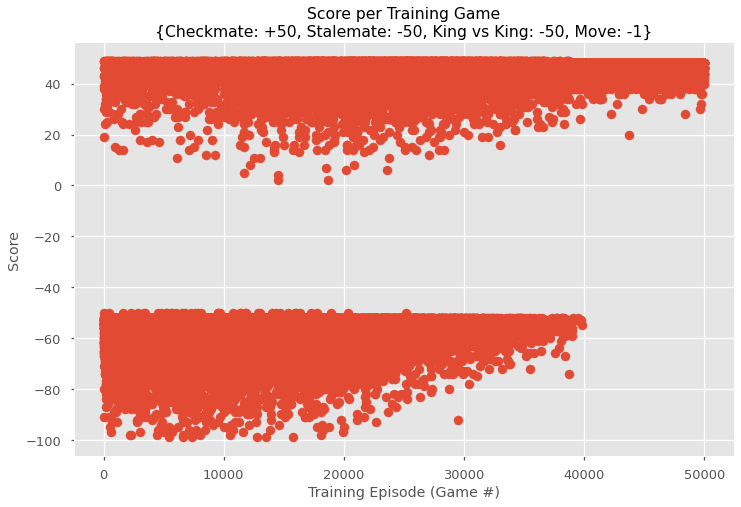

In [32]:
fig, ax = plt.subplots()
ax.scatter(x=range(1, TRAINING_EPISODES+1), y=episode_rewards_lst)
ax.set(
    title='Score per Training Game\n{Checkmate: +50, Stalemate: -50, King vs King: -50, Move: -1}',
    xlabel='Training Episode (Game #)',
    ylabel='Score'
)
fig.tight_layout()